In [131]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, PReLU, Input
from keras.optimizers import RMSprop, SGD, Adam
import tensorflow as tf
from PIL import Image
from skimage import io
import keras

In [15]:
Label_df = pd.read_csv("train_labels.csv")

Label_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [182]:
Label_df.shape

(220025, 3)

Our train set has over 220k pictures. I will use the above labels dataframe to create the directory for image extranction.

## Data Cleaning and EDA

### Create image paths

Let's also create the image paths for each image. 

In [16]:
Label_df["image_path"] = Label_df["id"].apply(lambda x: os.path.join("C:/Users/Johns/Desktop/Data/ca classification/train/", str(x) + ".tif"))

In [17]:
Label_df.head()

,id,label,image_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,C:/Users/Johns/Desktop/Data/ca classification/...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,C:/Users/Johns/Desktop/Data/ca classification/...
2,755db6279dae599ebb4d39a9123cce439965282d,0,C:/Users/Johns/Desktop/Data/ca classification/...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,C:/Users/Johns/Desktop/Data/ca classification/...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,C:/Users/Johns/Desktop/Data/ca classification/...


### Check for null values in the dataframe

checking for null values in the dataframe:

In [18]:
null_counts = Label_df.isna().sum()
print(null_counts)

id            0
label         0
image_path    0
dtype: int64


Good, we don't have any

### Check for label balance

checking label balance: 

In [19]:
label_counts = Label_df['label'].value_counts()

In [20]:
label_counts.head()

label
0    130908
1     89117
Name: count, dtype: int64

Text(0.5, 1.0, 'label counts')

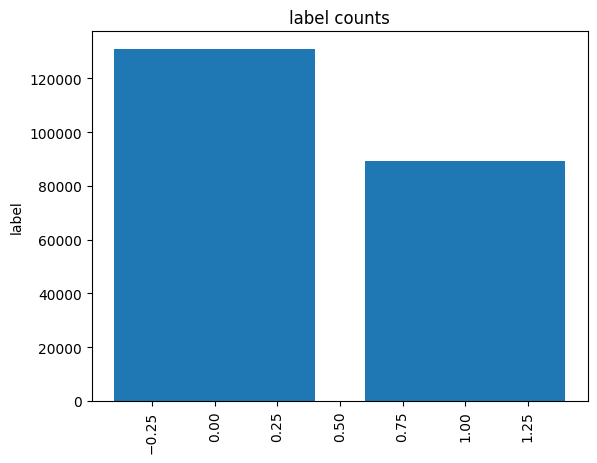

In [21]:
fig, ax = plt.subplots()
ax.bar(label_counts.index, label_counts.values)
plt.xticks(rotation=90)
ax.set_ylabel('label')
ax.set_title('label counts')

So we have unbalanced labels. 

Another thing worth noting here is that our dataset is quite large. Perhaps random sampling will reduce it to an acceptable size. 

### Check image sizes

Check the sizes of the images:

For this i will have to use random sampling. Otherwise our runtime will be absolutely horrendous

In [22]:
image_sizes = []
for index in np.random.randint(0, len(Label_df), 10000):
    image = io.imread(Label_df["image_path"].iloc[index])
    image_height, image_width, image_channels = image.shape
    if (image_height, image_width, image_channels) not in image_sizes:
        image_sizes.append((image_height, image_width, image_channels))
        

In [23]:
image_sizes

[(96, 96, 3)]

Okay, all of our images are of the same size. Cool. No rescaling needed. And it looks like our pictures have 3 color channels. Depending on how we decide to go with it we could grayscale everything for faster processing. 

BUt in this version I will be using all 3 channels to take advantage of things like staining used in microscopy. 

### Random sampling and balancing labels

Because we have umbalanced labels I will try to balance the labels when training the model. 

In [24]:
Label_1 = Label_df[Label_df.label == 1]

In [25]:
Label_1

,id,label,image_path
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,C:/Users/Johns/Desktop/Data/ca classification/...
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1,C:/Users/Johns/Desktop/Data/ca classification/...
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1,C:/Users/Johns/Desktop/Data/ca classification/...
11,c3d660212bf2a11c994e0eadff13770a9927b731,1,C:/Users/Johns/Desktop/Data/ca classification/...
14,94fa32b29cc1c00403176c0795fffa3cfaa0f20e,1,C:/Users/Johns/Desktop/Data/ca classification/...
...,...,...,...
220010,8a25b1632a1859d7b757e912ca673385b64e1b1d,1,C:/Users/Johns/Desktop/Data/ca classification/...
220012,3e24dd48c3a419f4d669cac3cf71e777ba100541,1,C:/Users/Johns/Desktop/Data/ca classification/...
220014,309210db7f424edbc22b2d13bf2fa27518b18f5c,1,C:/Users/Johns/Desktop/Data/ca classification/...
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1,C:/Users/Johns/Desktop/Data/ca classification/...


In [26]:
Label_0 = Label_df[Label_df.label == 0]

In [27]:
Label_0

,id,label,image_path
0,f38a6374c348f90b587e046aac6079959adf3835,0,C:/Users/Johns/Desktop/Data/ca classification/...
2,755db6279dae599ebb4d39a9123cce439965282d,0,C:/Users/Johns/Desktop/Data/ca classification/...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,C:/Users/Johns/Desktop/Data/ca classification/...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,C:/Users/Johns/Desktop/Data/ca classification/...
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0,C:/Users/Johns/Desktop/Data/ca classification/...
...,...,...,...
220018,cdf7171a796090072ce521012497c78c9a56cad3,0,C:/Users/Johns/Desktop/Data/ca classification/...
220019,1fdacc29221a64e39d5d294d114c9e29da8705ae,0,C:/Users/Johns/Desktop/Data/ca classification/...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0,C:/Users/Johns/Desktop/Data/ca classification/...
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0,C:/Users/Johns/Desktop/Data/ca classification/...


For this I am going to sample with replacement, to preserve the statistical property of our original data as much as possible. 

In [28]:
Label_1_sample = Label_1.sample(n = 50000, replace = True, random_state = 14)
Label_0_sample = Label_0.sample(n = 50000, replace = True, random_state = 14)

In [29]:
Label_1_sample

,id,label,image_path
195426,b9038dc7ad0d3bad4aeb307ead229a348aae2782,1,C:/Users/Johns/Desktop/Data/ca classification/...
23505,edc4b0213feef5cb31b1d3b032ac14e69892b471,1,C:/Users/Johns/Desktop/Data/ca classification/...
56380,79078225eed332dbdeae8a29ad4060b4f8a8756b,1,C:/Users/Johns/Desktop/Data/ca classification/...
111020,f1a691bb44aaee375fa4f93dc889493dd7667740,1,C:/Users/Johns/Desktop/Data/ca classification/...
193844,05203cfa1283f4bae26a93e24aba5f85c61aa2f5,1,C:/Users/Johns/Desktop/Data/ca classification/...
...,...,...,...
80966,b8d01eef4be6843fff3e3ce5dcf8d5202e208e1f,1,C:/Users/Johns/Desktop/Data/ca classification/...
216854,317d989629fdff00be579c7683f85ef06ef52f3c,1,C:/Users/Johns/Desktop/Data/ca classification/...
162899,99c6165e47dcb563fc9696585e744ad315f8b967,1,C:/Users/Johns/Desktop/Data/ca classification/...
177006,46e8de3e98953aca09b93a360cf3ee00a82a15ba,1,C:/Users/Johns/Desktop/Data/ca classification/...


In [30]:
Label_0_sample

,id,label,image_path
197241,c50a8c5eb0aeac3c8280b45f03965fe1e1410d9f,0,C:/Users/Johns/Desktop/Data/ca classification/...
132859,ad737c9207258f0cdfe0441f181ebac82a06c650,0,C:/Users/Johns/Desktop/Data/ca classification/...
15823,1b5f42c1fb80a39102531de04a0eb6c2614c12d9,0,C:/Users/Johns/Desktop/Data/ca classification/...
196903,fc2b331f3bd9ea1be6263638a3e77e0b37b13442,0,C:/Users/Johns/Desktop/Data/ca classification/...
38209,e16bb8907d3a1d6161bd3c902f85b0973f6b4146,0,C:/Users/Johns/Desktop/Data/ca classification/...
...,...,...,...
211880,206c5cd4d18f085b5d2f3e37efbc1d2d1c320dfe,0,C:/Users/Johns/Desktop/Data/ca classification/...
19447,5bf4b1d39502864ce81c9b7f0adaf5987bbaaefc,0,C:/Users/Johns/Desktop/Data/ca classification/...
195977,b2ca249b750950fe59b725ed1161fd1c00cdd863,0,C:/Users/Johns/Desktop/Data/ca classification/...
50143,807ec76bbaab1db583a00092e16efd6a26f39fb1,0,C:/Users/Johns/Desktop/Data/ca classification/...


In [31]:
Label_sample = pd.concat([Label_1_sample, Label_0_sample], axis = 0)

In [32]:
Label_sample

,id,label,image_path
195426,b9038dc7ad0d3bad4aeb307ead229a348aae2782,1,C:/Users/Johns/Desktop/Data/ca classification/...
23505,edc4b0213feef5cb31b1d3b032ac14e69892b471,1,C:/Users/Johns/Desktop/Data/ca classification/...
56380,79078225eed332dbdeae8a29ad4060b4f8a8756b,1,C:/Users/Johns/Desktop/Data/ca classification/...
111020,f1a691bb44aaee375fa4f93dc889493dd7667740,1,C:/Users/Johns/Desktop/Data/ca classification/...
193844,05203cfa1283f4bae26a93e24aba5f85c61aa2f5,1,C:/Users/Johns/Desktop/Data/ca classification/...
...,...,...,...
211880,206c5cd4d18f085b5d2f3e37efbc1d2d1c320dfe,0,C:/Users/Johns/Desktop/Data/ca classification/...
19447,5bf4b1d39502864ce81c9b7f0adaf5987bbaaefc,0,C:/Users/Johns/Desktop/Data/ca classification/...
195977,b2ca249b750950fe59b725ed1161fd1c00cdd863,0,C:/Users/Johns/Desktop/Data/ca classification/...
50143,807ec76bbaab1db583a00092e16efd6a26f39fb1,0,C:/Users/Johns/Desktop/Data/ca classification/...


### Image extraction for model training

For this part  Iam using a trick suggested by this source:

https://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy

In [33]:
images = []
for path in Label_sample.image_path:
    im = Image.open(path)
    imarray = np.array(im)
    images.append(imarray)

In [34]:
images = np.array(images)

In [35]:
X_train, X_vali, y_train, y_vali = train_test_split(images, Label_sample.label, test_size=0.2, train_size=0.8,random_state = 25)

## Model training and architecture/hyperparameter tuning

### Stride = 2 model

For this project I will use an architecture analogous to the VGGNet architecture discussed in class. 

But I will make some modifications to it.  

Instead of using maxpool like in the VGGNet I will try to use a different stride size. 

In [78]:
#learning_rate = 0.001
#optimizer = Adam(learning_rate=learning_rate)

model1 = Sequential()
#pool_size = (2, 2)
filter_size = (3, 3)

model1.add(Conv2D(filters = 8, kernel_size=filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))

model1.add(BatchNormalization())

model1.add(Conv2D(filters = 8, kernel_size = filter_size, activation='relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(filters = 8, kernel_size = filter_size, strides = (2,2), activation=None))

model1.add(Conv2D(filters = 16, kernel_size = filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 16, kernel_size=filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 16, kernel_size = filter_size, strides = (2,2), activation=None))

model1.add(Conv2D(filters = 32, kernel_size = filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 32, kernel_size=filter_size, activation='relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters = 32, kernel_size = filter_size, strides = (2,2), activation=None))

model1.add(Flatten())

model1.add(Dropout(0.5))
model1.add(Dense(1024, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [79]:
model1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 94, 94, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 94, 94, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 92, 92, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 92, 92, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 45, 45, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 43, 43, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 43, 43, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 41, 41, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 41, 41, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 20, 20, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 18, 18, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │     1,606,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,692,161 (10.27 MB)

 Trainable params: 2,689,889 (10.26 MB)

 Non-trainable params: 2,272 (8.88 KB)

Okay we are ready to train. While training I will record the training and validation loss so that we can make a plot in a later section. 

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

record = model1.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_vali, y_vali))

In [107]:
#model1 = keras.models.load_model('model_ADAM10-3_9Conv_relu_stride2_epoch100_filter3x3_batchNorm+dropout.keras')

In [108]:
model1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 94, 94, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 94, 94, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 92, 92, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 92, 92, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 45, 45, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 43, 43, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 43, 43, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 41, 41, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 41, 41, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 20, 20, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 18, 18, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │     1,606,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,071,941 (30.79 MB)

 Trainable params: 2,689,889 (10.26 MB)

 Non-trainable params: 2,272 (8.88 KB)

 Optimizer params: 5,379,780 (20.52 MB)

SInce the model takes so long to train I will be saving the training data as well as the model in external files. 

In [85]:
#model1.save('model_ADAM10-3_9Conv_relu_stride2_epoch100_filter3x3_batchNorm+dropout.keras')

In [86]:
record.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [122]:
def makeDFofHist(history):
    model_record = pd.DataFrame([x for x in range(1,101)], columns=['epoch'])
    model_record = model_record.assign(accuracy=history.history['accuracy'])
    model_record = model_record.assign(loss=history.history['loss'])
    model_record = model_record.assign(validation_accuracy=history.history['val_accuracy'])
    model_record = model_record.assign(validation_loss=history.history['val_loss'])
    return model_record

In [126]:
model1_record = makeDFofHist(record)

In [127]:
model1_record

,epoch,accuracy,loss,validation_accuracy,validation_loss
0,1,0.800438,0.449525,0.81995,0.413040
1,2,0.838325,0.374110,0.85085,0.416440
2,3,0.852325,0.342462,0.85180,0.337215
3,4,0.865462,0.314830,0.79545,0.465253
4,5,0.878438,0.292178,0.84715,0.349132
...,...,...,...,...,...
95,96,0.971850,0.076415,0.91360,0.350816
96,97,0.971275,0.078834,0.91420,0.286037
97,98,0.973200,0.072681,0.91630,0.314442
98,99,0.971637,0.076560,0.91725,0.294788


In [128]:
#model1_record.to_csv(path_or_buf='model_ADAM10-3_9Conv_relu_stride2_epoch100_filter3x3_batchNorm+dropout.csv')

### maxpool model

For this version I will try to use an architecture more similar to VGGNet. just like last model I will be incorporating batch normalization and dropout. 

In [96]:
model2 = Sequential()
pool_size = (2, 2)
filter_size = (3, 3)

model2.add(Conv2D(filters = 8, kernel_size=filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 8, kernel_size = filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

model2.add(Conv2D(filters = 16, kernel_size = filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 16, kernel_size=filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

model2.add(Conv2D(filters = 32, kernel_size = filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 32, kernel_size=filter_size, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=pool_size))

model2.add(Flatten())

model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [97]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
record2 = model2.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_vali, y_vali))

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 103s 621ms/step - accuracy: 0.7432 - loss: 0.6000 - val_accuracy: 0.4836 - val_loss: 1.7447
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 101s 644ms/step - accuracy: 0.8322 - loss: 0.3935 - val_accuracy: 0.7282 - val_loss: 0.6242
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 103s 655ms/step - accuracy: 0.8510 - loss: 0.3474 - val_accuracy: 0.6727 - val_loss: 1.3005
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 102s 651ms/step - accuracy: 0.8605 - loss: 0.3254 - val_accuracy: 0.8307 - val_loss: 0.3698
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 637ms/step - accuracy: 0.8682 - loss: 0.3105 - val_accuracy: 0.7880 - val_loss: 0.4389
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 638ms/step - accuracy: 0.8743 - loss: 0.2959 - val_accuracy: 0.8475 - val_loss: 0.3739
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 635ms/step - accuracy: 0.8850 - loss: 0.2786 - val_accuracy: 0.8512 - val_loss: 0.3859
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 638ms/step - accuracy: 

Let's save this model as well. 

In [98]:
#model2.save('model_ADAM10-3_9Conv_relu_maxpool_epoch100_filter3x3_batchNorm+dropout.keras')

In [99]:
model2.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_118 (Conv2D)             │ (None, 94, 94, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 94, 94, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 92, 92, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 92, 92, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 44, 44, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 44, 44, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 42, 42, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 42, 42, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 21, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 19, 19, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 19, 19, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 17, 17, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 17, 17, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,510,045 (36.28 MB)

 Trainable params: 3,169,257 (12.09 MB)

 Non-trainable params: 2,272 (8.88 KB)

 Optimizer params: 6,338,516 (24.18 MB)

In [179]:
#record2.history['accuracy']

In [ ]:
'''
model2_record = pd.DataFrame([x for x in range(1,101)], columns=['epoch'])
model2_record = model2_record.assign(accuracy=record2.history['accuracy'])
model2_record = model2_record.assign(loss=record2.history['loss'])
model2_record = model2_record.assign(validation_accuracy=record2.history['val_accuracy'])
model2_record = model2_record.assign(validation_loss=record2.history['val_loss'])
'''

In [123]:
model2_record = makeDFofHist(record2)

In [124]:
model2_record

,epoch,accuracy,loss,validation_accuracy,validation_loss
0,1,0.784875,0.496273,0.48360,1.744665
1,2,0.833337,0.384508,0.72815,0.624213
2,3,0.851237,0.346589,0.67275,1.300472
3,4,0.861000,0.324807,0.83070,0.369778
4,5,0.868187,0.309686,0.78805,0.438881
...,...,...,...,...,...
95,96,0.981013,0.053171,0.92105,0.299068
96,97,0.981875,0.050046,0.86440,0.559825
97,98,0.981500,0.049301,0.92860,0.265679
98,99,0.981150,0.052419,0.92395,0.274839


In [125]:
#model2_record.to_csv(path_or_buf='model_ADAM10-3_9Conv_relu_maxpool_epoch100_filter3x3_batchNorm+dropout.csv')

### PReLU activation models

#### fast learning rate

FOr the next model  Iwill be using one that uses PReLU activation

In [133]:
model3 = Sequential()
#pool_size = (2, 2)
filter_size = (3, 3)
model3.add(Input(shape = (image_width, image_height, image_channels)))
model3.add(Conv2D(filters = 8, kernel_size=filter_size, activation=None, input_shape=(image_width, image_height, image_channels)))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 8, kernel_size = filter_size, activation=None))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 8, kernel_size = filter_size, strides = (2,2), activation=None))
model3.add(Conv2D(filters = 16, kernel_size = filter_size, activation=None))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 16, kernel_size=filter_size, activation=None))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 16, kernel_size = filter_size, strides = (2,2), activation=None))

model3.add(Conv2D(filters = 32, kernel_size = filter_size, activation=None))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 32, kernel_size = filter_size, activation=None))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(BatchNormalization())
model3.add(Conv2D(filters = 32, kernel_size = filter_size, strides = (2,2), activation=None))

model3.add(Flatten())

model3.add(Dropout(0.5))
model3.add(Dense(1024, activation=None))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation=None))
model3.add(PReLU(alpha_initializer="Zeros"))
model3.add(Dense(1, activation='sigmoid'))

In [134]:
model3.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
record3 = model3.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_vali, y_vali))

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 837ms/step - accuracy: 0.7363 - loss: 0.5875 - val_accuracy: 0.4999 - val_loss: 1.5161
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 883ms/step - accuracy: 0.8225 - loss: 0.4090 - val_accuracy: 0.7003 - val_loss: 0.6361
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 137s 872ms/step - accuracy: 0.8424 - loss: 0.3635 - val_accuracy: 0.8204 - val_loss: 0.4539
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 149s 952ms/step - accuracy: 0.8604 - loss: 0.3292 - val_accuracy: 0.8111 - val_loss: 0.4355
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 909ms/step - accuracy: 0.8720 - loss: 0.3026 - val_accuracy: 0.8454 - val_loss: 0.3613
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 893ms/step - accuracy: 0.8864 - loss: 0.2732 - val_accuracy: 0.8368 - val_loss: 0.4043
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 151s 962ms/step - accuracy: 0.9027 - loss: 0.2416 - val_accuracy: 0.8488 - val_loss: 0.3919
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 154s 978ms/step - accuracy: 

In [135]:
model3_record = makeDFofHist(record3)

In [136]:
model3_record

,epoch,accuracy,loss,validation_accuracy,validation_loss
0,1,0.776625,0.502980,0.49985,1.516093
1,2,0.829763,0.393584,0.70025,0.636148
2,3,0.843250,0.361274,0.82040,0.453881
3,4,0.859788,0.327005,0.81110,0.435488
4,5,0.873025,0.302197,0.84545,0.361349
...,...,...,...,...,...
95,96,0.996600,0.009770,0.86165,1.543607
96,97,0.996650,0.009896,0.84285,1.622022
97,98,0.996662,0.009563,0.82465,2.096632
98,99,0.995138,0.014437,0.84280,1.392277


In [137]:
model3_record.to_csv(path_or_buf='model_ADAM10-3_9Conv_Prelu_stride2_epoch100_filter3x3_batchNorm+dropout.csv')

In [138]:
model3.save('model_ADAM10-3_9Conv_Prelu_stride2_epoch100_filter3x3_batchNorm+dropout.keras')

In [139]:
model3.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_160 (Conv2D)             │ (None, 94, 94, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_36 (PReLU)              │ (None, 94, 94, 8)      │        70,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_128         │ (None, 94, 94, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 92, 92, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_37 (PReLU)              │ (None, 92, 92, 8)      │        67,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 92, 92, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_162 (Conv2D)             │ (None, 45, 45, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_163 (Conv2D)             │ (None, 43, 43, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_38 (PReLU)              │ (None, 43, 43, 16)     │        29,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 43, 43, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 41, 41, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_39 (PReLU)              │ (None, 41, 41, 16)     │        26,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 41, 41, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_165 (Conv2D)             │ (None, 20, 20, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_166 (Conv2D)             │ (None, 18, 18, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_40 (PReLU)              │ (None, 18, 18, 32)     │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_167 (Conv2D)             │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_41 (PReLU)              │ (None, 16, 16, 32)     │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_168 (Conv2D)             │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 1568)           │             

 Total params: 8,718,405 (33.26 MB)

 Trainable params: 2,905,377 (11.08 MB)

 Non-trainable params: 2,272 (8.88 KB)

 Optimizer params: 5,810,756 (22.17 MB)

#### Slow learning rate

In [140]:
model4 = Sequential()
#pool_size = (2, 2)
filter_size = (3, 3)
model4.add(Input(shape = (image_width, image_height, image_channels)))
model4.add(Conv2D(filters = 8, kernel_size=filter_size, activation=None, input_shape=(image_width, image_height, image_channels)))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(BatchNormalization())
model4.add(Conv2D(filters = 8, kernel_size = filter_size, activation=None))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(BatchNormalization())
model4.add(Conv2D(filters = 8, kernel_size = filter_size, strides = (2,2), activation=None))
model4.add(Conv2D(filters = 16, kernel_size = filter_size, activation=None))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(BatchNormalization())
model4.add(Conv2D(filters = 16, kernel_size=filter_size, activation=None))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(BatchNormalization())
model4.add(Conv2D(filters = 16, kernel_size = filter_size, strides = (2,2), activation=None))

model4.add(Conv2D(filters = 32, kernel_size = filter_size, activation=None))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(BatchNormalization())
model4.add(Conv2D(filters = 32, kernel_size = filter_size, activation=None))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(BatchNormalization())
model4.add(Conv2D(filters = 32, kernel_size = filter_size, strides = (2,2), activation=None))

model4.add(Flatten())

model4.add(Dropout(0.5))
model4.add(Dense(1024, activation=None))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(1024, activation=None))
model4.add(PReLU(alpha_initializer="Zeros"))
model4.add(Dense(1, activation='sigmoid'))

C:\Users\Johns\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [142]:
model4.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
record4 = model4.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_vali, y_vali))

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 134s 801ms/step - accuracy: 0.6369 - loss: 0.6895 - val_accuracy: 0.6306 - val_loss: 0.6629
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 136s 865ms/step - accuracy: 0.7589 - loss: 0.5144 - val_accuracy: 0.7391 - val_loss: 0.5442
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 144s 919ms/step - accuracy: 0.7746 - loss: 0.4823 - val_accuracy: 0.7885 - val_loss: 0.4650
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 138s 878ms/step - accuracy: 0.7880 - loss: 0.4606 - val_accuracy: 0.7975 - val_loss: 0.4543
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 132s 840ms/step - accuracy: 0.8009 - loss: 0.4386 - val_accuracy: 0.8027 - val_loss: 0.4593
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 139s 884ms/step - accuracy: 0.8068 - loss: 0.4282 - val_accuracy: 0.8138 - val_loss: 0.4329
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 148s 945ms/step - accuracy: 0.8148 - loss: 0.4160 - val_accuracy: 0.8151 - val_loss: 0.4322
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 140s 892ms/step - accuracy: 

In [143]:
model4_record = makeDFofHist(record4)

In [144]:
model4_record

,epoch,accuracy,loss,validation_accuracy,validation_loss
0,1,0.688062,0.618574,0.63055,0.662930
1,2,0.762537,0.508024,0.73910,0.544243
2,3,0.775700,0.480130,0.78845,0.465018
3,4,0.790625,0.456110,0.79750,0.454254
4,5,0.801150,0.438875,0.80270,0.459314
...,...,...,...,...,...
95,96,0.957000,0.111184,0.87630,0.520334
96,97,0.956400,0.112208,0.87315,0.516728
97,98,0.958550,0.108259,0.87230,0.557742
98,99,0.958637,0.105689,0.87225,0.535689


In [145]:
model4_record.to_csv(path_or_buf='model_ADAM10-5_9Conv_Prelu_stride2_epoch100_filter3x3_batchNorm+dropout.csv')

In [146]:
model4.save('model_ADAM10-5_9Conv_Prelu_stride2_epoch100_filter3x3_batchNorm+dropout.keras')

In [149]:
model1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 94, 94, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 94, 94, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 92, 92, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 92, 92, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 45, 45, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 43, 43, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 43, 43, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 41, 41, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 41, 41, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 20, 20, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 18, 18, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 18, 18, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │     1,606,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,692,161 (10.27 MB)

 Trainable params: 2,689,889 (10.26 MB)

 Non-trainable params: 2,272 (8.88 KB)

### ReLU slower learning rate

#### Medium batch size

In [150]:
model5 = Sequential()
#pool_size = (2, 2)
filter_size = (3, 3)

model5.add(Conv2D(filters = 8, kernel_size=filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))

model5.add(BatchNormalization())

model5.add(Conv2D(filters = 8, kernel_size = filter_size, activation='relu'))
model5.add(BatchNormalization())

model5.add(Conv2D(filters = 8, kernel_size = filter_size, strides = (2,2), activation=None))

model5.add(Conv2D(filters = 16, kernel_size = filter_size, activation='relu'))
model5.add(BatchNormalization())
model5.add(Conv2D(filters = 16, kernel_size=filter_size, activation='relu'))
model5.add(BatchNormalization())
model5.add(Conv2D(filters = 16, kernel_size = filter_size, strides = (2,2), activation=None))

model5.add(Conv2D(filters = 32, kernel_size = filter_size, activation='relu'))
model5.add(BatchNormalization())
model5.add(Conv2D(filters = 32, kernel_size=filter_size, activation='relu'))
model5.add(BatchNormalization())
model5.add(Conv2D(filters = 32, kernel_size = filter_size, strides = (2,2), activation=None))

model5.add(Flatten())

model5.add(Dropout(0.5))
model5.add(Dense(1024, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(1024, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

C:\Users\Johns\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [151]:
model5.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [152]:
record5 = model5.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_vali, y_vali))

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 281s 110ms/step - accuracy: 0.7385 - loss: 0.5505 - val_accuracy: 0.7783 - val_loss: 0.4831
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 273s 109ms/step - accuracy: 0.8052 - loss: 0.4368 - val_accuracy: 0.8218 - val_loss: 0.4064
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 272s 109ms/step - accuracy: 0.8163 - loss: 0.4154 - val_accuracy: 0.8192 - val_loss: 0.4061
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 278s 111ms/step - accuracy: 0.8301 - loss: 0.3910 - val_accuracy: 0.8493 - val_loss: 0.3535
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 289s 116ms/step - accuracy: 0.8377 - loss: 0.3723 - val_accuracy: 0.8528 - val_loss: 0.3610
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 293s 117ms/step - accuracy: 0.8434 - loss: 0.3622 - val_accuracy: 0.8605 - val_loss: 0.3292
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 292s 117ms/step - accuracy: 0.8521 - loss: 0.3438 - val_accuracy: 0.8663 - val_loss: 0.3220
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 266s 107ms/s

In [153]:
model5_record = makeDFofHist(record5)

In [154]:
model5_record

,epoch,accuracy,loss,validation_accuracy,validation_loss
0,1,0.769325,0.501220,0.77830,0.483147
1,2,0.805763,0.435707,0.82180,0.406443
2,3,0.819488,0.410260,0.81925,0.406093
3,4,0.831350,0.387196,0.84925,0.353460
4,5,0.839850,0.369184,0.85280,0.361047
...,...,...,...,...,...
95,96,0.964688,0.092510,0.90590,0.327966
96,97,0.962963,0.096862,0.90825,0.328350
97,98,0.964350,0.092446,0.90275,0.318228
98,99,0.964063,0.094461,0.90690,0.309968


In [155]:
model5_record.to_csv(path_or_buf='model_ADAM10-4_9Conv_relu_stride2_epoch100_filter3x3_batchNorm+dropout.csv')

In [156]:
model5.save('model_ADAM10-4_9Conv_relu_stride2_epoch100_filter3x3_batchNorm+dropout.keras')

#### Large batch size

In [171]:
model6 = Sequential()
#pool_size = (2, 2)
filter_size = (3, 3)

model6.add(Conv2D(filters =16, kernel_size=filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model6.add(BatchNormalization())
model6.add(Conv2D(filters = 16, kernel_size = filter_size, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(filters = 16, kernel_size = filter_size, strides = (2,2), activation=None))

model6.add(Conv2D(filters = 32, kernel_size = filter_size, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(filters = 32, kernel_size=filter_size, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(filters = 32, kernel_size = filter_size, strides = (2,2), activation=None))

model6.add(Conv2D(filters = 64, kernel_size = filter_size, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(filters = 64, kernel_size=filter_size, activation='relu'))
model6.add(BatchNormalization())
model6.add(Conv2D(filters = 64, kernel_size = filter_size, strides = (2,2), activation=None))

model6.add(Flatten())

model6.add(Dropout(0.5))
model6.add(Dense(1024, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))
model6.add(Dense(1024, activation='relu'))
model6.add(Dense(1, activation='sigmoid'))

In [172]:
model6.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [173]:
model6.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_242 (Conv2D)             │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_189         │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_243 (Conv2D)             │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_190         │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_244 (Conv2D)             │ (None, 45, 45, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_245 (Conv2D)             │ (None, 43, 43, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_191         │ (None, 43, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_246 (Conv2D)             │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_192         │ (None, 41, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_247 (Conv2D)             │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_248 (Conv2D)             │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_193         │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_249 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_194         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_250 (Conv2D)             │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_195         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,388,481 (16.74 MB)

 Trainable params: 4,385,985 (16.73 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [174]:
record6 = model6.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_vali, y_vali))

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.7327 - loss: 0.5640 - val_accuracy: 0.6396 - val_loss: 0.6265
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7935 - loss: 0.4559 - val_accuracy: 0.7376 - val_loss: 0.5321
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8175 - loss: 0.4131 - val_accuracy: 0.7808 - val_loss: 0.5399
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8298 - loss: 0.3914 - val_accuracy: 0.8030 - val_loss: 0.4849
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8388 - loss: 0.3700 - val_accuracy: 0.7804 - val_loss: 0.5104
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8451 - loss: 0.3577 - val_accuracy: 0.8371 - val_loss: 0.3904
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8549 - loss: 0.3412 - val_accuracy: 0.8480 - val_loss: 0.3654
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8614 - loss: 0.3279 - 

In [218]:
model6_record = makeDFofHist(record6)

#### Small batch size

In [175]:
model7 = Sequential()
#pool_size = (2, 2)
filter_size = (3, 3)

model7.add(Conv2D(filters =16, kernel_size=filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)))
model7.add(BatchNormalization())
model7.add(Conv2D(filters = 16, kernel_size = filter_size, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(filters = 16, kernel_size = filter_size, strides = (2,2), activation=None))

model7.add(Conv2D(filters = 32, kernel_size = filter_size, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(filters = 32, kernel_size=filter_size, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(filters = 32, kernel_size = filter_size, strides = (2,2), activation=None))

model7.add(Conv2D(filters = 64, kernel_size = filter_size, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(filters = 64, kernel_size=filter_size, activation='relu'))
model7.add(BatchNormalization())
model7.add(Conv2D(filters = 64, kernel_size = filter_size, strides = (2,2), activation=None))

model7.add(Flatten())

model7.add(Dropout(0.5))
model7.add(Dense(1024, activation='relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))
model7.add(Dense(1024, activation='relu'))
model7.add(Dense(1, activation='sigmoid'))

In [176]:
model7.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [177]:
model7.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_251 (Conv2D)             │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_196         │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_252 (Conv2D)             │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_197         │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_253 (Conv2D)             │ (None, 45, 45, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_254 (Conv2D)             │ (None, 43, 43, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_198         │ (None, 43, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_255 (Conv2D)             │ (None, 41, 41, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_199         │ (None, 41, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_256 (Conv2D)             │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_257 (Conv2D)             │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_200         │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_258 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_201         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_259 (Conv2D)             │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1024)           │     3,212,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_202         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,388,481 (16.74 MB)

 Trainable params: 4,385,985 (16.73 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [178]:
record7 = model7.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_vali, y_vali))

Epoch 1/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 491s 97ms/step - accuracy: 0.7378 - loss: 0.5610 - val_accuracy: 0.8115 - val_loss: 0.4237
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 472s 94ms/step - accuracy: 0.8075 - loss: 0.4369 - val_accuracy: 0.8393 - val_loss: 0.3664
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 461s 92ms/step - accuracy: 0.8344 - loss: 0.3860 - val_accuracy: 0.8465 - val_loss: 0.3569
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 456s 91ms/step - accuracy: 0.8528 - loss: 0.3428 - val_accuracy: 0.8447 - val_loss: 0.3605
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 476s 95ms/step - accuracy: 0.8663 - loss: 0.3130 - val_accuracy: 0.8831 - val_loss: 0.2986
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 479s 96ms/step - accuracy: 0.8832 - loss: 0.2826 - val_accuracy: 0.8908 - val_loss: 0.2725
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 471s 94ms/step - accuracy: 0.8946 - loss: 0.2582 - val_accuracy: 0.8730 - val_loss: 0.3123
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 472s 94ms/step - ac

In [219]:
model7_record = makeDFofHist(record7)

## Model evaluation

In [223]:
def plot_train_and_valid(history):
    epochs = history.epoch

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.loss, label='training', color='green')
    plt.plot(epochs, history.validation_loss, label='validation', color='magenta')
    plt.xlabel('epochs')
    plt.title('loss by epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.accuracy, label='training', color='blue')
    plt.plot(epochs, history.validation_accuracy, label='validation', color='orange')
    plt.xlabel('epochs')
    plt.title('accuracy by epoch')
    plt.legend()

### Stride = 2 model

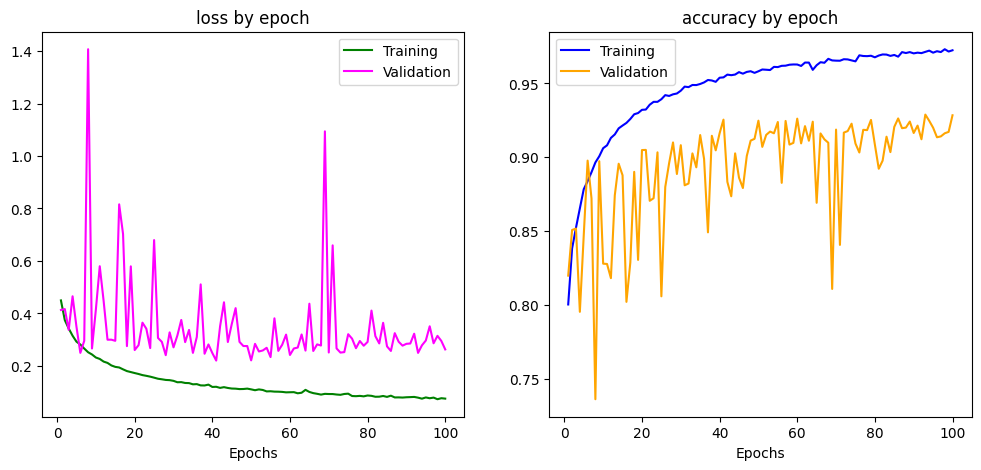

In [224]:
plot_train_and_valid(model1_record)

### maxpool model

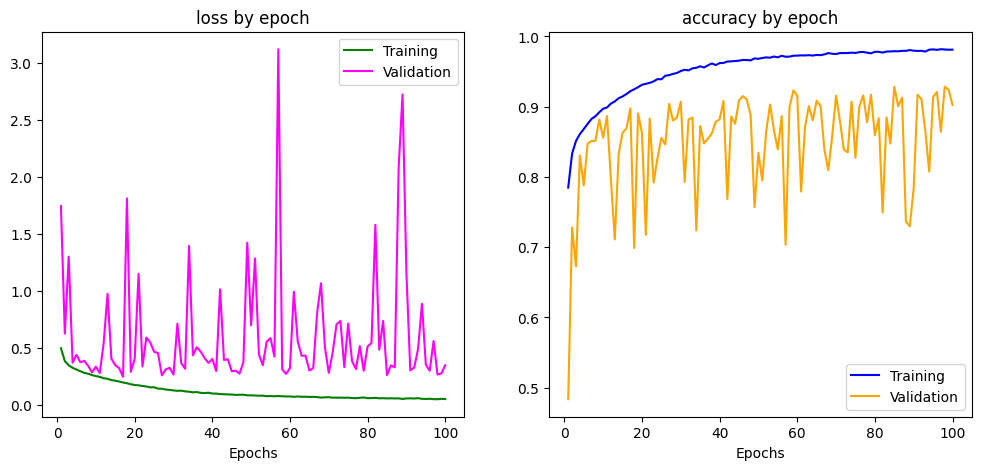

In [207]:
plot_train_and_valid(model2_record)

### PReLU activation models

#### fast learning rate

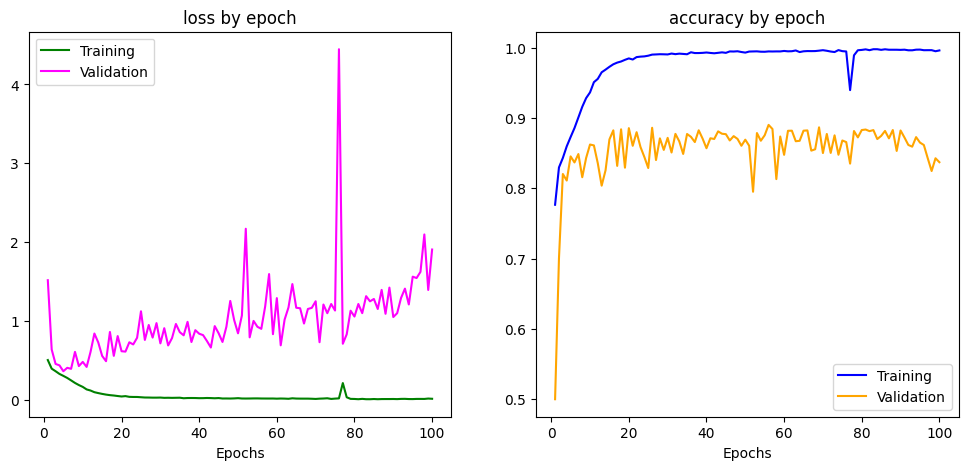

In [208]:
plot_train_and_valid(model3_record)

#### Slow learning rate

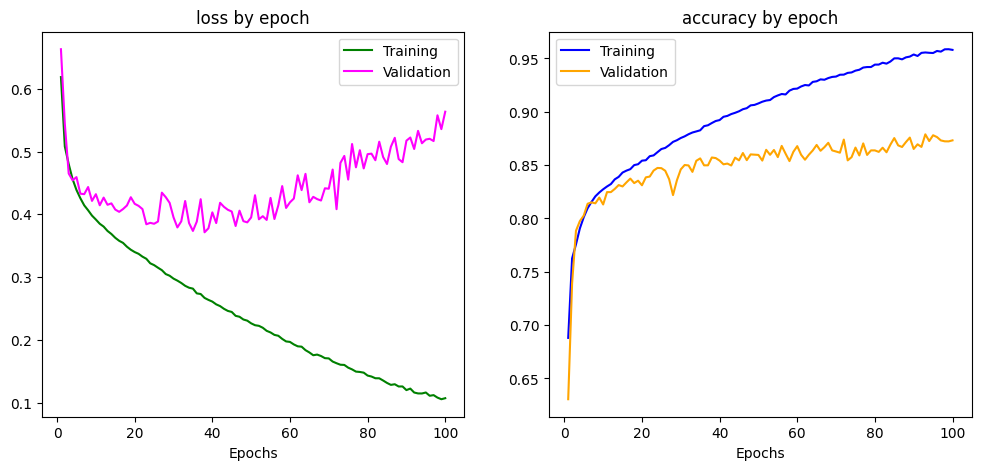

In [209]:
plot_train_and_valid(model4_record)

### ReLU slower learning rate

#### Medium batch size

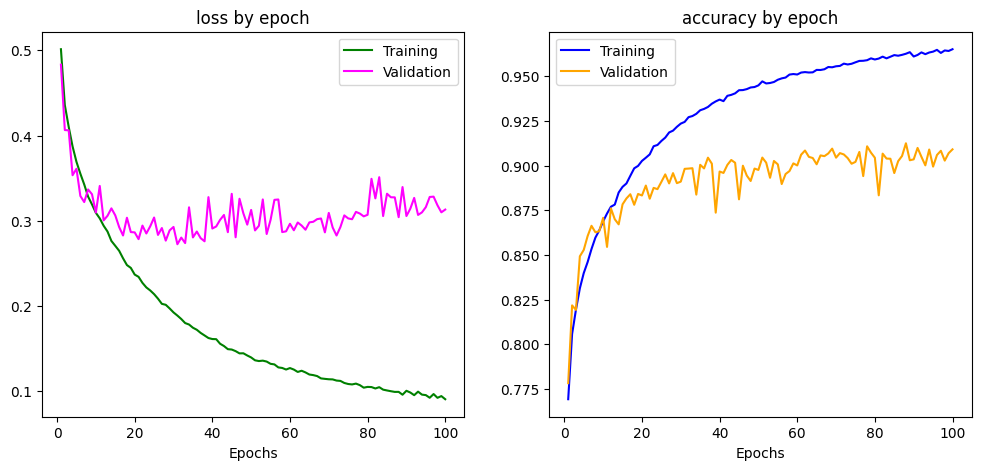

In [210]:
plot_train_and_valid(model5_record)

#### Large batch size

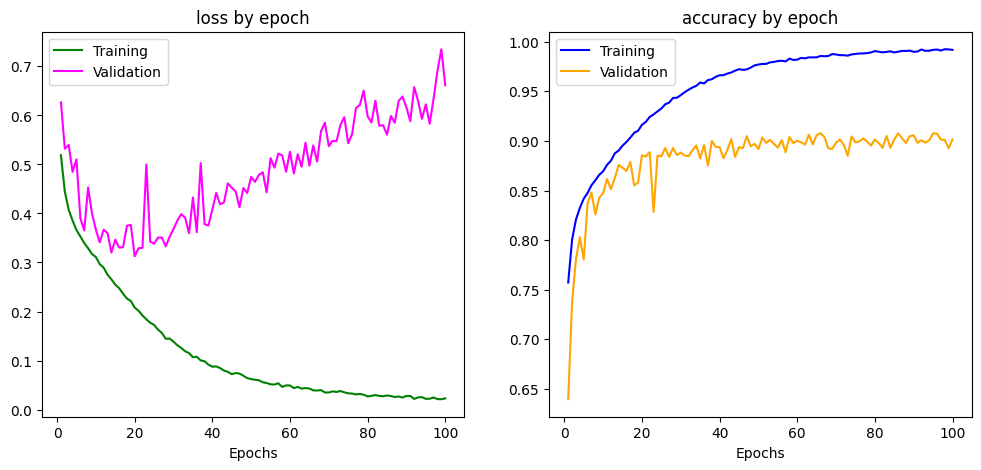

In [215]:
plot_train_and_valid(model6_record)

#### Small batch size

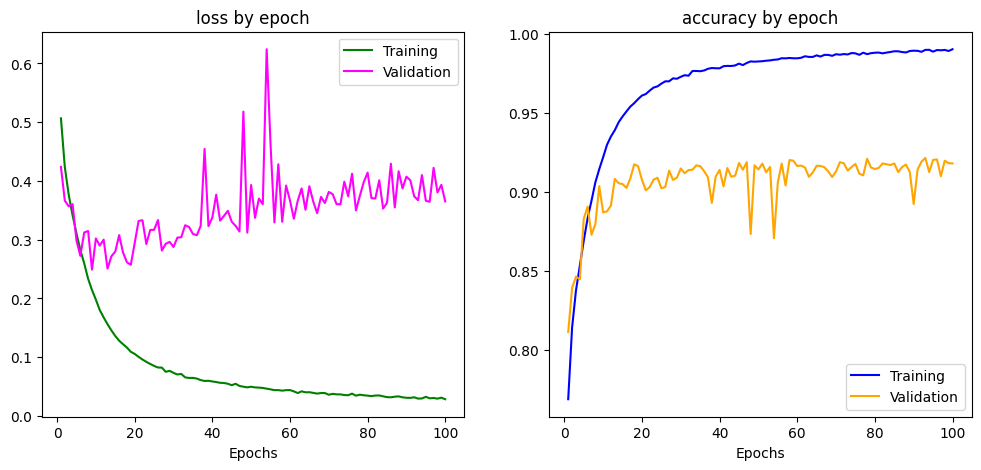

In [220]:
plot_train_and_valid(model7_record)

## summary and discussions

1. Both stride = 2 and maxpool work fine. Though it seems like that the stride = 2 model with no activation is more stable during training evidenced by lower fluctuations at high epoch numbers.

2. PRelu Model works no better then ReLU. PReLU with low learning rate didn't perform better when compared to the equivalent model with ReLU and large batch size.

3. smaller batch size gave a lower minimum validation loss than larger batch. Suggesting that using smaller batches helps with making the model train better.

4. Based on the above plots the slow learning rate small batch size models work best. I will employ early stopping to obtain the best model.

## Creating submission prediction

In [242]:
filter_size = (3, 3)
model8 = Sequential([
    Conv2D(filters =16, kernel_size=filter_size, activation='relu', input_shape=(image_width, image_height, image_channels)),
    BatchNormalization(),
    Conv2D(filters = 16, kernel_size = filter_size, activation='relu'),
    BatchNormalization(),
    Conv2D(filters = 16, kernel_size = filter_size, strides = (2,2), activation=None),

    Conv2D(filters = 32, kernel_size = filter_size, activation='relu'),
    BatchNormalization(),
    Conv2D(filters = 32, kernel_size = filter_size, activation='relu'),
    BatchNormalization(),
    Conv2D(filters = 32, kernel_size = filter_size, strides = (2,2), activation=None),

    Conv2D(filters = 64, kernel_size = filter_size, activation='relu'),
    BatchNormalization(),
    Conv2D(filters = 64, kernel_size = filter_size, activation='relu'),
    BatchNormalization(),
    Conv2D(filters = 64, kernel_size = filter_size, strides = (2,2), activation=None),
    
    Flatten(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
model8.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights = True, start_from_epoch=10)

In [243]:
record8 = model8.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_vali, y_vali), callbacks = [callback])

Epoch 1/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1567s 312ms/step - accuracy: 0.7303 - loss: 0.5499 - val_accuracy: 0.8171 - val_loss: 0.4243
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1497s 299ms/step - accuracy: 0.8043 - loss: 0.4317 - val_accuracy: 0.8468 - val_loss: 0.3620
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1388s 278ms/step - accuracy: 0.8290 - loss: 0.3870 - val_accuracy: 0.8622 - val_loss: 0.3412
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1371s 274ms/step - accuracy: 0.8462 - loss: 0.3524 - val_accuracy: 0.8828 - val_loss: 0.2921
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1359s 272ms/step - accuracy: 0.8639 - loss: 0.3215 - val_accuracy: 0.8869 - val_loss: 0.2686
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1359s 272ms/step - accuracy: 0.8753 - loss: 0.3024 - val_accuracy: 0.8910 - val_loss: 0.2650
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1360s 272ms/step - accuracy: 0.8834 - loss: 0.2825 - val_accuracy: 0.8875 - val_loss: 0.2688
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1354s

In [255]:
submission_df = pd.DataFrame(columns=["id"])

test_file_paths = []
for location, _, files in os.walk("C:/Users/Johns/Desktop/Data/ca classification/test/"):
    for name in files:
        test_file_paths.append(os.path.join(location, name))
images = []
for i in range(len(test_file_paths)):
    image = Image.open(test_file_paths[i])
    id = test_file_paths[i].split("/")[-1].split(".")[0]
    submission_df.loc[len(submission_df) + 1] = id
    images.append(np.array(image))

images = np.array(images)
prediction = model8.predict(images)
label = np.where(prediction > 0.5, 1, 0)
submission_df = submission_df.assign(label=label)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 292s 163ms/step


In [256]:
submission_df

,id,label
1,00006537328c33e284c973d7b39d340809f7271b,1
2,0000ec92553fda4ce39889f9226ace43cae3364e,1
3,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
4,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
5,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57454,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57455,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57456,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57457,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


In [257]:
submission_df.to_csv("submission.csv", index=False)

The final score I got from kaggle is 0.8184. 

This is a AUC score so is not the same as the accuracy score used in this notebook. Let's try to find our AUC score from the validation set. 

In [258]:
auc = keras.metrics.AUC()

auc.update_state(y_vali, model8.predict(X_vali))

auc.result()

625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.9718603>

Looks like our validation set AUC is much higher. This could be a sign of overfitting or a sign that the sample is not representative of the images. 

It makes sense if the sample is not fully representative. Afterall we balanced the labels and so the sample is obviously not entirely representative. But otherwise this is rather dissapointing performance. Perhaps overfitting is a problem here because our model architecture is too complex, even though I attempted to reduce the problem using regualrization. 